In [ ]:
import os, json

# 🔹 REPLACE THESE WITH YOUR REAL INFO
KAGGLE_USERNAME = "retajalhazmi"   # username
KAGGLE_KEY = "KGAT_1c14718a8d2787332d4e6ce3289c7b60"  # real token

# Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Create kaggle.json file
kaggle_json = {
    "username": KAGGLE_USERNAME,
    "key": KAGGLE_KEY
}

# Write kaggle.json with username and key
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

# Correct permissions (Owner can read/write)
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# Install kaggle CLI
!pip install kaggle


In [ ]:
# Download the dataset
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip it into folder fer2013
!unzip fer2013.zip -d fer2013


Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

In [ ]:
# Just to double-check folders exist
!ls fer2013
!ls fer2013/train


test  train
angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
import shutil

# original FER-2013 folders
src_train = "fer2013/train"
src_test  = "fer2013/test"

# new stress dataset folders
dst_train = "fer2013_stress/train"
dst_test  = "fer2013_stress/test"

# Stress class
classes_stress   = ["angry", "disgust", "fear"]
# No_stress class
classes_nostress = ["happy", "neutral"]

# helper function to copy images into stress / no_stress folders
def copy_split(src_base, dst_base):
    # create stress/no_stress subfolders
    os.makedirs(os.path.join(dst_base, "stress"), exist_ok=True)
    os.makedirs(os.path.join(dst_base, "no_stress"), exist_ok=True)

    # stress classes
    for c in classes_stress:
        src_dir = os.path.join(src_base, c)
        for fname in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, fname),
                        os.path.join(dst_base, "stress", f"{c}_{fname}"))

    # no-stress classes
    for c in classes_nostress:
        src_dir = os.path.join(src_base, c)
        for fname in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, fname),
                        os.path.join(dst_base, "no_stress", f"{c}_{fname}"))

# build the new stress/no_stress split for train and test
copy_split(src_train, dst_train)
copy_split(src_test, dst_test)

# check new folders
!ls fer2013_stress
!ls fer2013_stress/train
!ls fer2013_stress/test


test  train
no_stress  stress
no_stress  stress


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (48, 48) # images are 48x48
batch_size = 64

train_dir = "fer2013_stress/train" # path to train images (stress/no_stress)
test_dir  = "fer2013_stress/test" # path to test images (stress/no_stress)

# data augmentation + rescaling for training
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0,1]
    rotation_range=15,      # random rotations
    width_shift_range=0.1,  # horizontal shift
    height_shift_range=0.1, # vertical shift
    horizontal_flip=True,   # random left-right flip
    validation_split=0.2    # 20% for validation
)

# only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# training subset (80% of train_dir)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",  # read images as black and white
    class_mode="binary",     # class 0, class1
    batch_size=batch_size,
    shuffle=True,
    subset="training"
)

# validation subset (from the same folder)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=False,
    subset="validation"
)

# independent test set (from fer2013_stress/test)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=False
)


Found 16567 images belonging to 2 classes.
Found 4141 images belonging to 2 classes.
Found 5100 images belonging to 2 classes.


In [ ]:
# Class labels
print(train_gen.class_indices)  # should show {'no_stress': 0, 'stress': 1}


{'no_stress': 0, 'stress': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN model for binary classification
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)), # Grayscale

    layers.Conv2D(32, (3,3), activation="relu", padding="same"), # conv layer: 32 filters, 3x3, keeps size same
    layers.MaxPooling2D(2,2),                                    # downsample: reduce width/height by 2

    layers.Conv2D(64, (3,3), activation="relu", padding="same"), # conv layer: 64 filters, 3x3, keeps size same
    layers.MaxPooling2D(2,2),                                    # downsample: reduce width/height by 2

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),# conv layer: 128 filters, 3x3, keeps size same
    layers.MaxPooling2D(2,2),                                    # downsample: reduce width/height by 2

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),                    # Regularization
    layers.Dense(1, activation="sigmoid")   # binary: no_stress(0) / stress(1)
])

# Compile model with binary crossentropy for 2 classes
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary() # Print model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the CNN for 20 times
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 91s 344ms/step - accuracy: 0.5817 - loss: 0.6817 - val_accuracy: 0.6025 - val_loss: 0.6637
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 86s 332ms/step - accuracy: 0.6045 - loss: 0.6639 - val_accuracy: 0.6288 - val_loss: 0.6573
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 89s 343ms/step - accuracy: 0.6237 - loss: 0.6486 - val_accuracy: 0.6320 - val_loss: 0.6432
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 89s 344ms/step - accuracy: 0.6519 - loss: 0.6301 - val_accuracy: 0.6525 - val_loss: 0.6225
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 89s 344ms/step - accuracy: 0.6658 - loss: 0.6141 - val_accuracy: 0.6868 - val_loss: 0.5838
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 89s 344ms/step - accuracy: 0.6778 - loss: 0.6026 - val_accuracy: 0.6926 - val_loss: 0.5671
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 89s 345ms/step - accuracy: 0.6970 - loss: 0.5764 - val_accuracy: 0.7266 - val_loss: 0.5300
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 90s 347ms/step - accuracy: 0.7159 - loss: 0

80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step
Accuracy:  0.7894
Precision: 0.7738
Recall:    0.6880
F1-score:  0.7284
ROC AUC:   0.8783


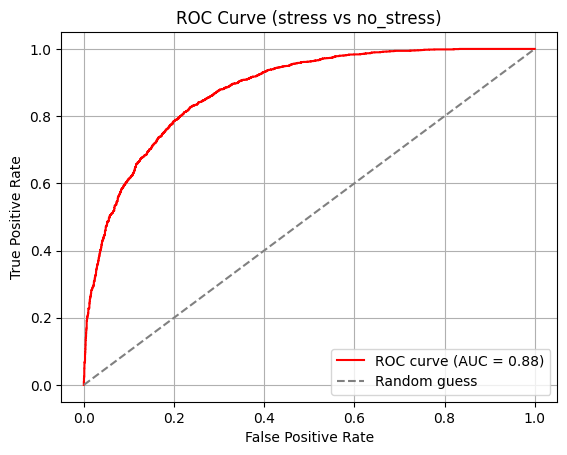

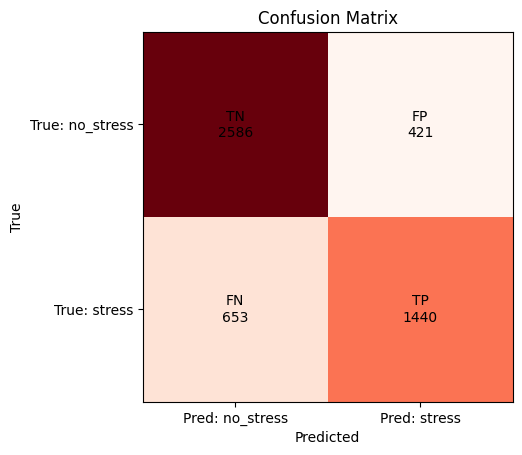

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_true = test_gen.classes # true labels for test set
y_proba = model.predict(test_gen) # predicted probabilities from model in range [0,1]
y_pred  = (y_proba > 0.5).astype("int32").ravel() # convert probabilities to 0/1 using 0.5 threshold

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()  # [[TN, FP], [FN, TP]]

# Metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
rocA = roc_auc_score(y_true, y_proba)  # use probabilities, not y_pred

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {rocA:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)  # use probs

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {rocA:.2f})", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (stress vs no_stress)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.imshow(cm, cmap="Reds")
plt.xticks([0, 1], ["Pred: no_stress", "Pred: stress"])
plt.yticks([0, 1], ["True: no_stress", "True: stress"])
labels = [["TN", "FP"],
          ["FN", "TP"]]
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{labels[i][j]}\n{cm[i, j]}", ha="center", va="center")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import math
from tensorflow.keras.preprocessing.image import load_img

# class index → name (from train_gen.class_indices)
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
print(idx_to_class)   # should be {0: 'no_stress', 1: 'stress'}

# base folder and relative file paths for test images
base_dir   = test_gen.directory     # "fer2013_stress/test"
file_paths = test_gen.filenames     # relative paths inside base_dir

def plot_misclassified(y_true, y_pred, y_proba,
                       true_label=None, pred_label=None,
                       max_images=12, title="Misclassified"):
    """
    true_label, pred_label: 0 or 1 or None
      - if both given → filter e.g. non-stress→stress
      - if None → show all misclassified
    """
    # all wrong predictions
    wrong = np.where(y_true != y_pred)[0]

    # filter only keep true=1, pred=0 with high confidence
    if true_label is not None and pred_label is not None:
        wrong = [i for i in wrong if y_true[i] == true_label and y_pred[i] == pred_label]

    # Limit number of images to display
    wrong = wrong[:max_images]
    n = len(wrong)
    if n == 0:
        print("No samples matching this condition.")
        return

    cols = 3                       # Number of columns in the grid
    rows = math.ceil(n / cols)     # rows needed for n images

    plt.figure(figsize=(cols*4, rows*4))
    plt.suptitle(f"{title}: {n}", fontsize=14)

    for i, idx in enumerate(wrong):
        # Build full path to image file
        img_path = os.path.join(base_dir, file_paths[idx])
        # Load images as 48x48 grayscale
        img = load_img(img_path, color_mode="grayscale", target_size=(48, 48))
        # Add subplot for this image
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        # Get human readable class names for true and predicted labels
        t_name = idx_to_class[y_true[idx]]
        p_name = idx_to_class[y_pred[idx]]
        # Model probability for class 1 (stress)
        score  = float(y_proba[idx][0])
        # Show labels and score as title
        plt.title(f"True: {t_name}\nPred: {p_name}\nscore={score:.2f}",
                  fontsize=9)
    # adjust layout so title and subplots don't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


{0: 'no_stress', 1: 'stress'}


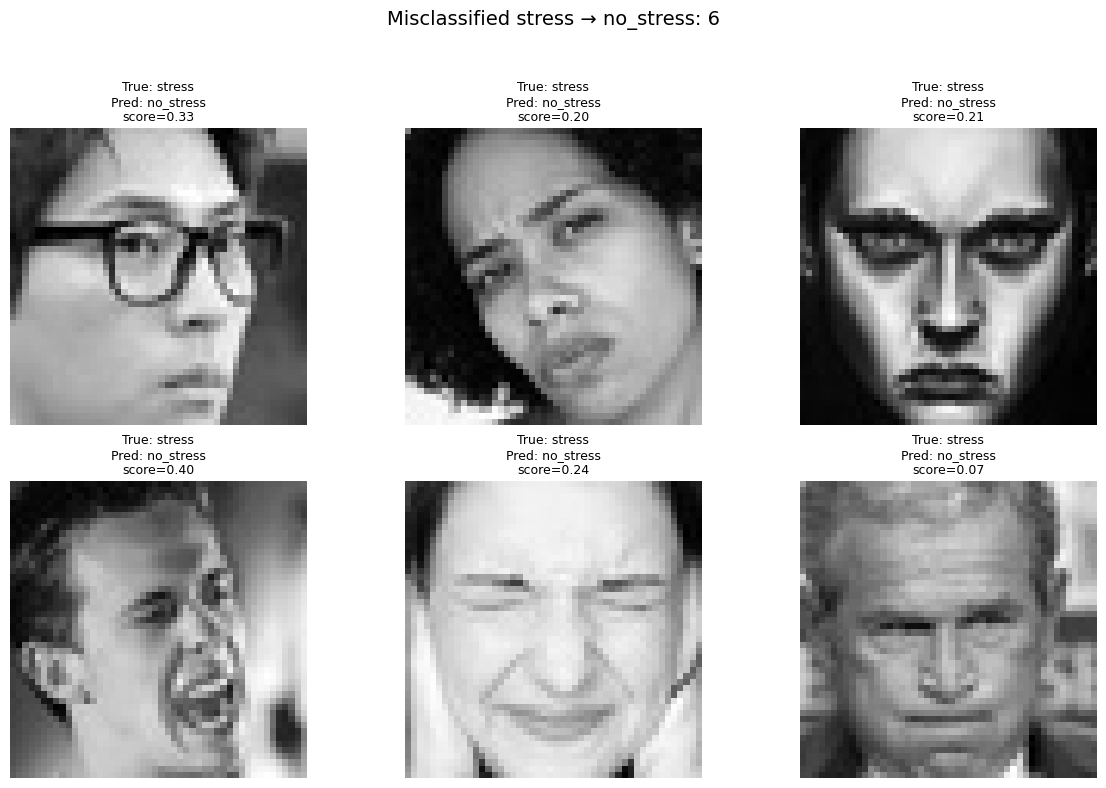

In [ ]:
# False Negative examples
plot_misclassified(
    y_true, y_pred, y_proba,
    true_label=1,        # real class = stress
    pred_label=0,        # predicted = no_stress
    max_images=6,        # show up to 6 examples
    title="Misclassified stress → no_stress"
)


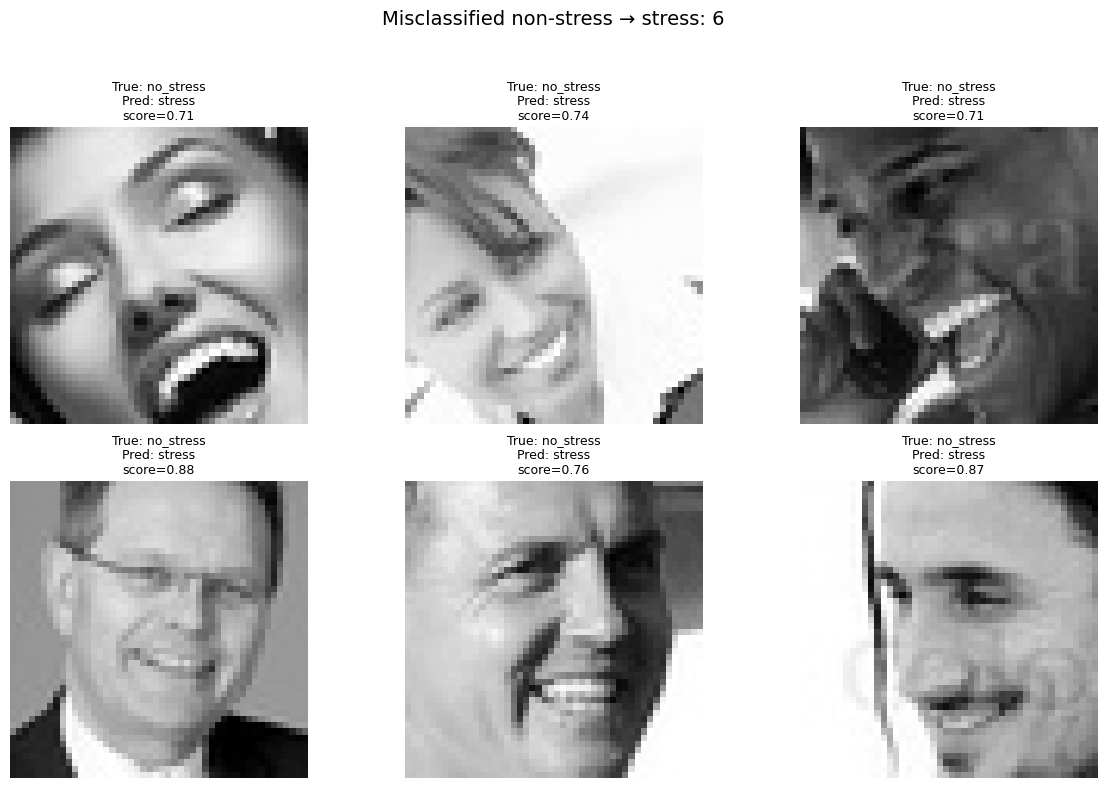

In [ ]:
# False Positive
plot_misclassified(
    y_true, y_pred, y_proba,
    true_label=0,  # real class = no_stress
    pred_label=1,  # predicted = stress
    max_images=6,
    title="Misclassified non-stress → stress"
)



In [ ]:
def plot_correct(
    y_true, y_pred, y_proba,
    label=None,       # 0 = no_stress, 1 = stress, or None for both
    max_images=12,
    title="Correctly classified"
):
    # indices where prediction is correct
    correct = np.where(y_true == y_pred)[0]

    # Only show correct example of a specific class
    if label is not None:
        correct = [i for i in correct if y_true[i] == label]

    # Limit to max_images
    correct = correct[:max_images]
    n = len(correct)
    if n == 0:
        print("No samples found for this condition.")
        return

    cols = 3
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols*4, rows*4))
    plt.suptitle(f"{title}: {n}", fontsize=14)

    for i, idx in enumerate(correct):
        img_path = os.path.join(base_dir, file_paths[idx])
        img = load_img(img_path, color_mode="grayscale", target_size=(48, 48))

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        c_name = idx_to_class[y_true[idx]]   # Class name (no_stress or stress)
        score  = float(y_proba[idx][0])      # predicted prob. of stress

        plt.title(f"True/Pred: {c_name}\nscore={score:.2f}", fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


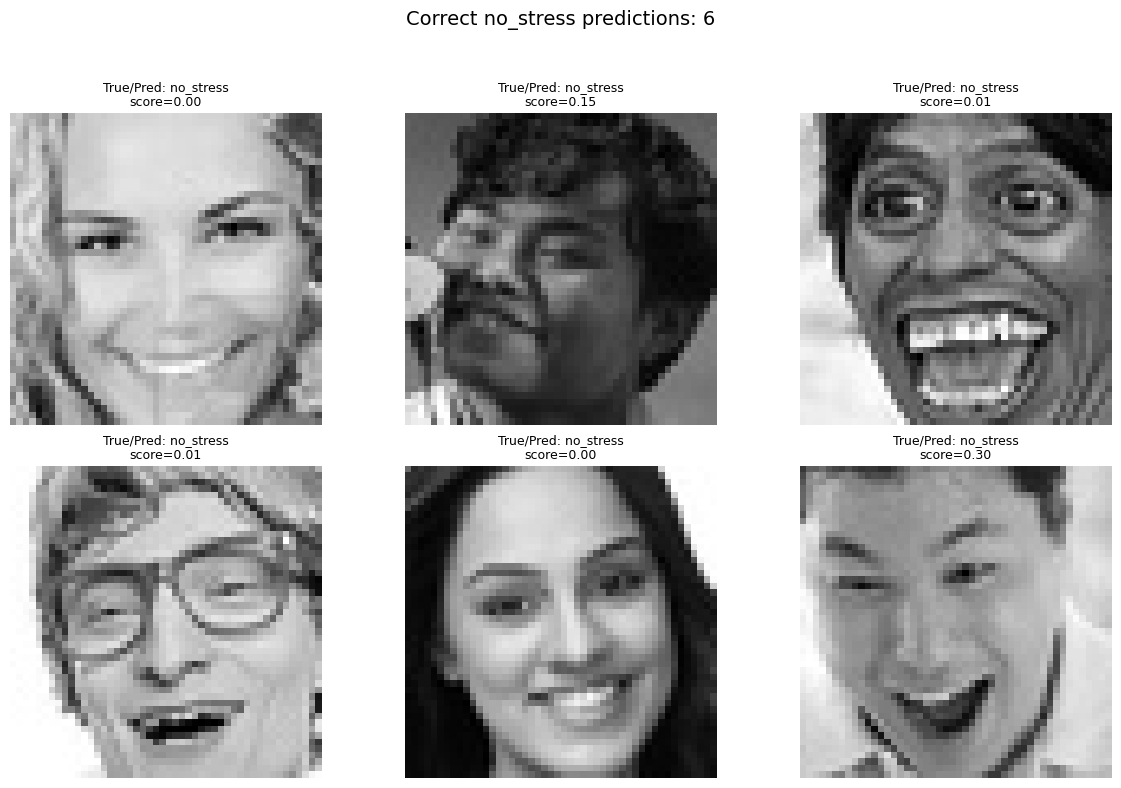

In [ ]:
# True Negative examples
plot_correct(
    y_true, y_pred, y_proba,
    label=0,              # 0 = no_stress
    max_images=6,
    title="Correct no_stress predictions"
)


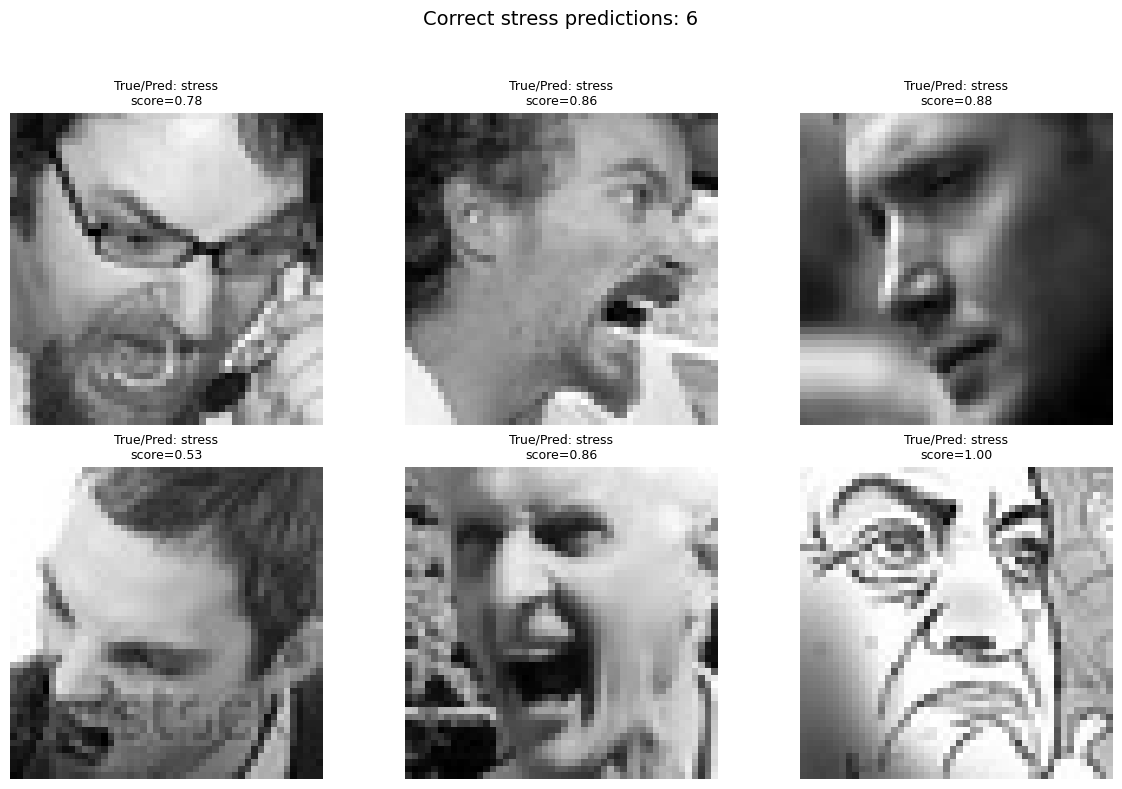

In [ ]:
# True Positive examples
plot_correct(
    y_true, y_pred, y_proba,
    label=1,              # 1 = stress
    max_images=6,
    title="Correct stress predictions"
)
